In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_fMullerBrown.recursive_LSTM_PostMeanScore_MullerBrown_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


2.0963334543460816 0.040098348612704005 inf


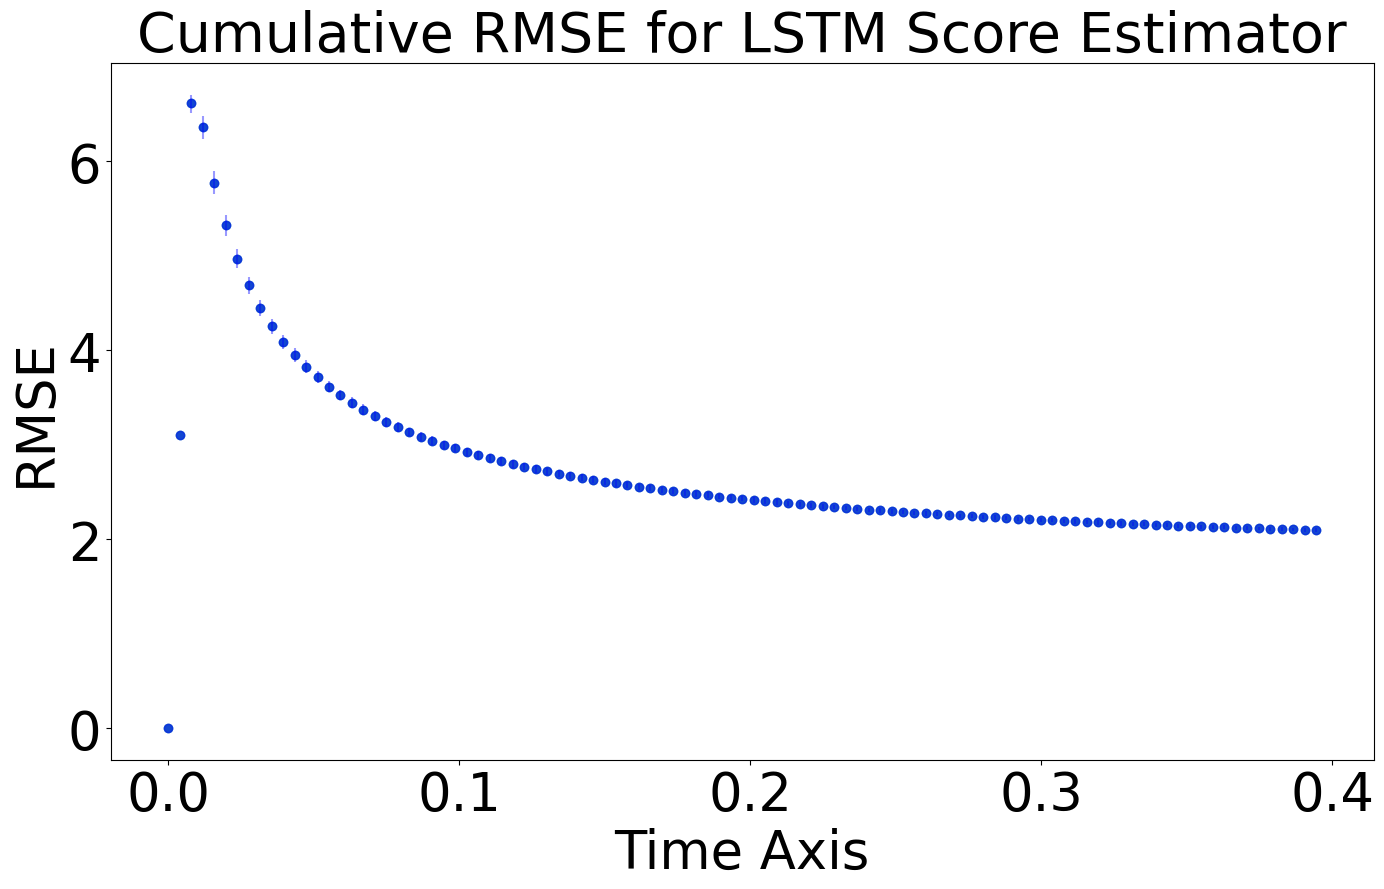

Final time cumulative RMSE local-time error 2.0963334543460816 with final IQR (2.0757472271658113, 2.1158455757785153) at Nepoch 60

1.9990073966012214 0.035804052444875945 2.0963334543460816


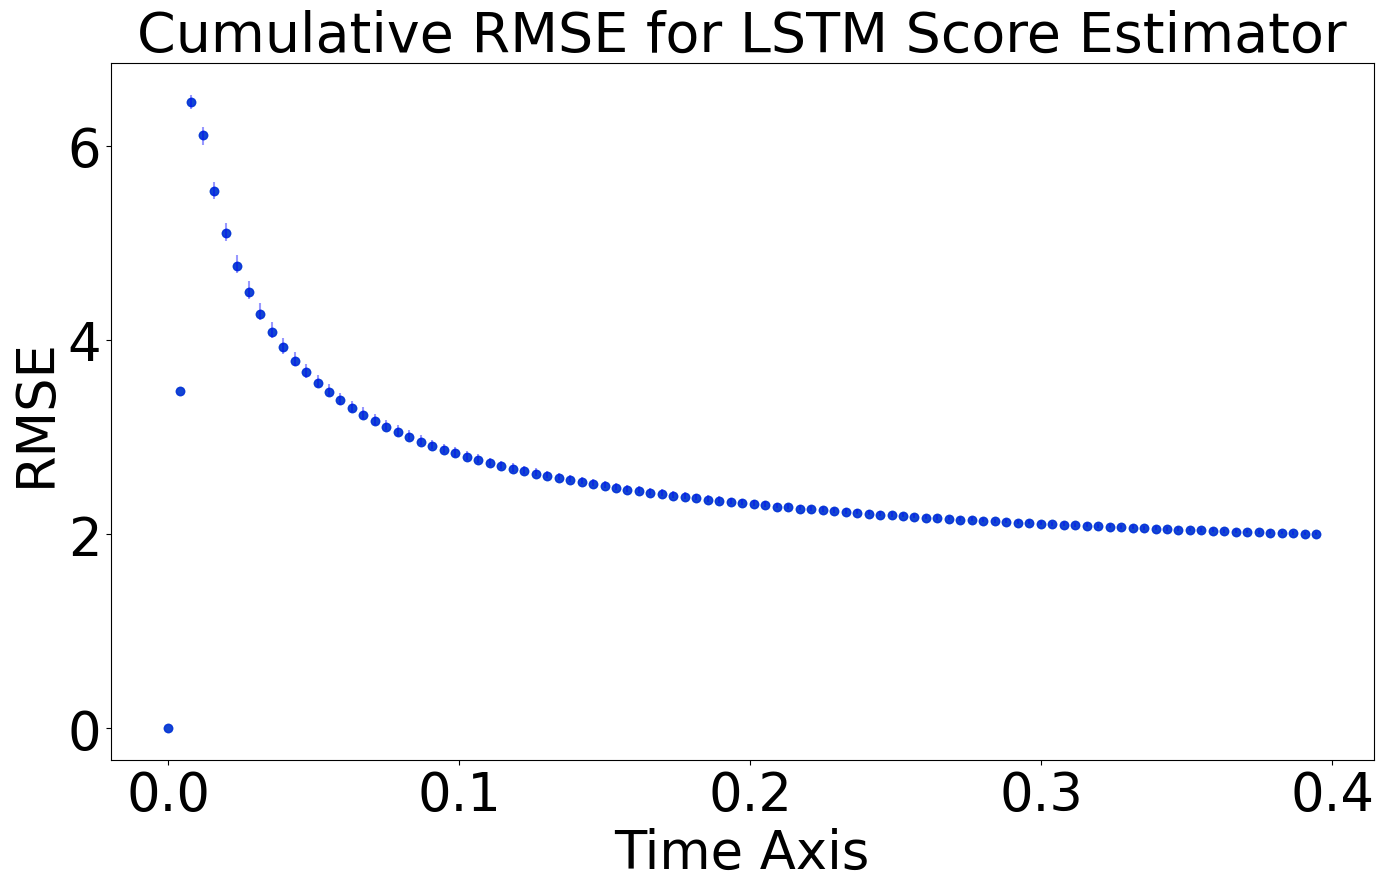

Final time cumulative RMSE local-time error 1.9990073966012214 with final IQR (1.9859837661266233, 2.0217878185714993) at Nepoch 100

1.966577304249596 0.025597327636313505 1.9990073966012214


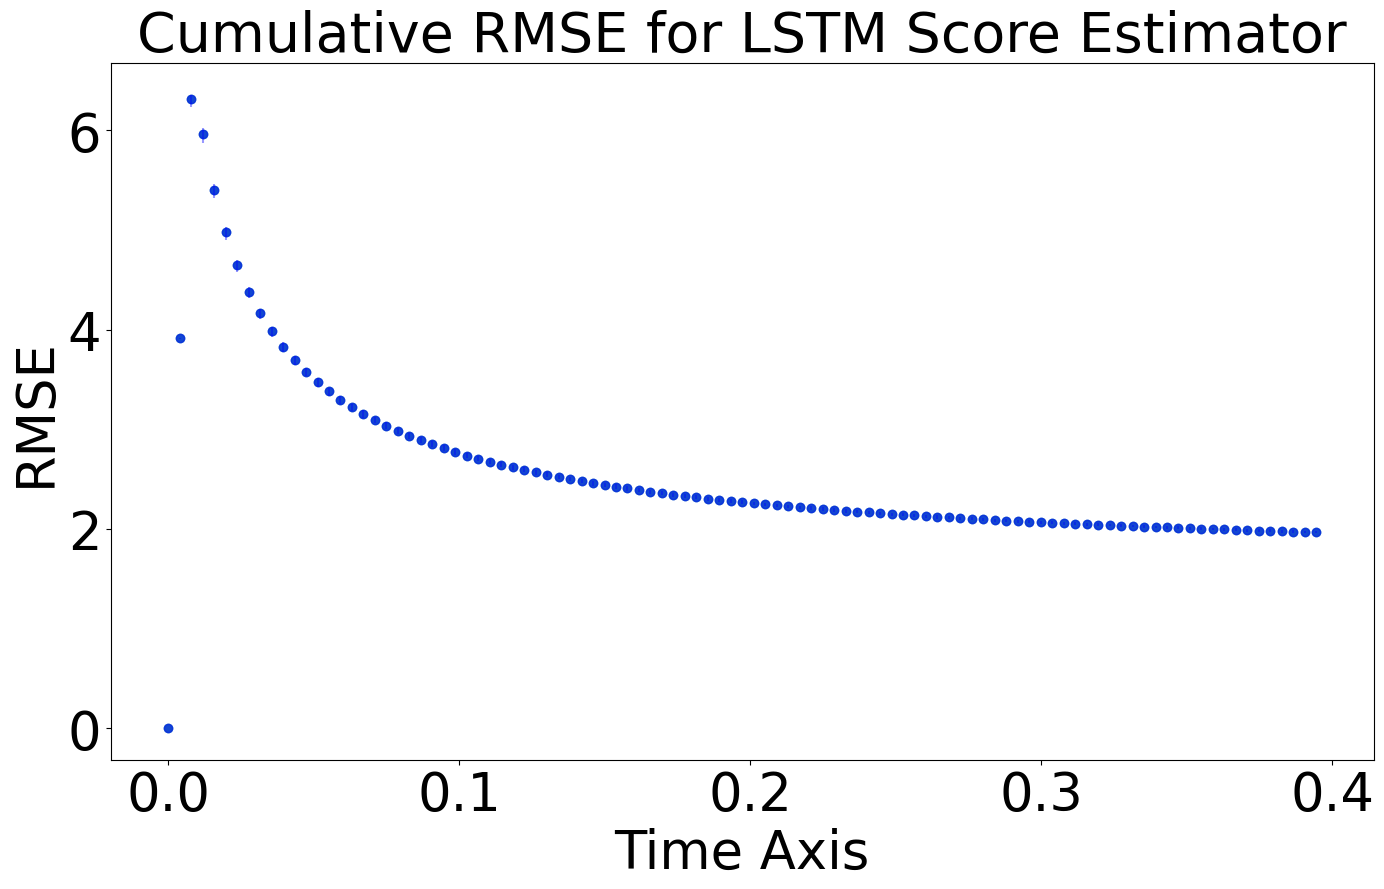

Final time cumulative RMSE local-time error 1.966577304249596 with final IQR (1.9539658827535997, 1.9795632103899132) at Nepoch 150

1.721410318331256 0.024372333518354328 1.966577304249596


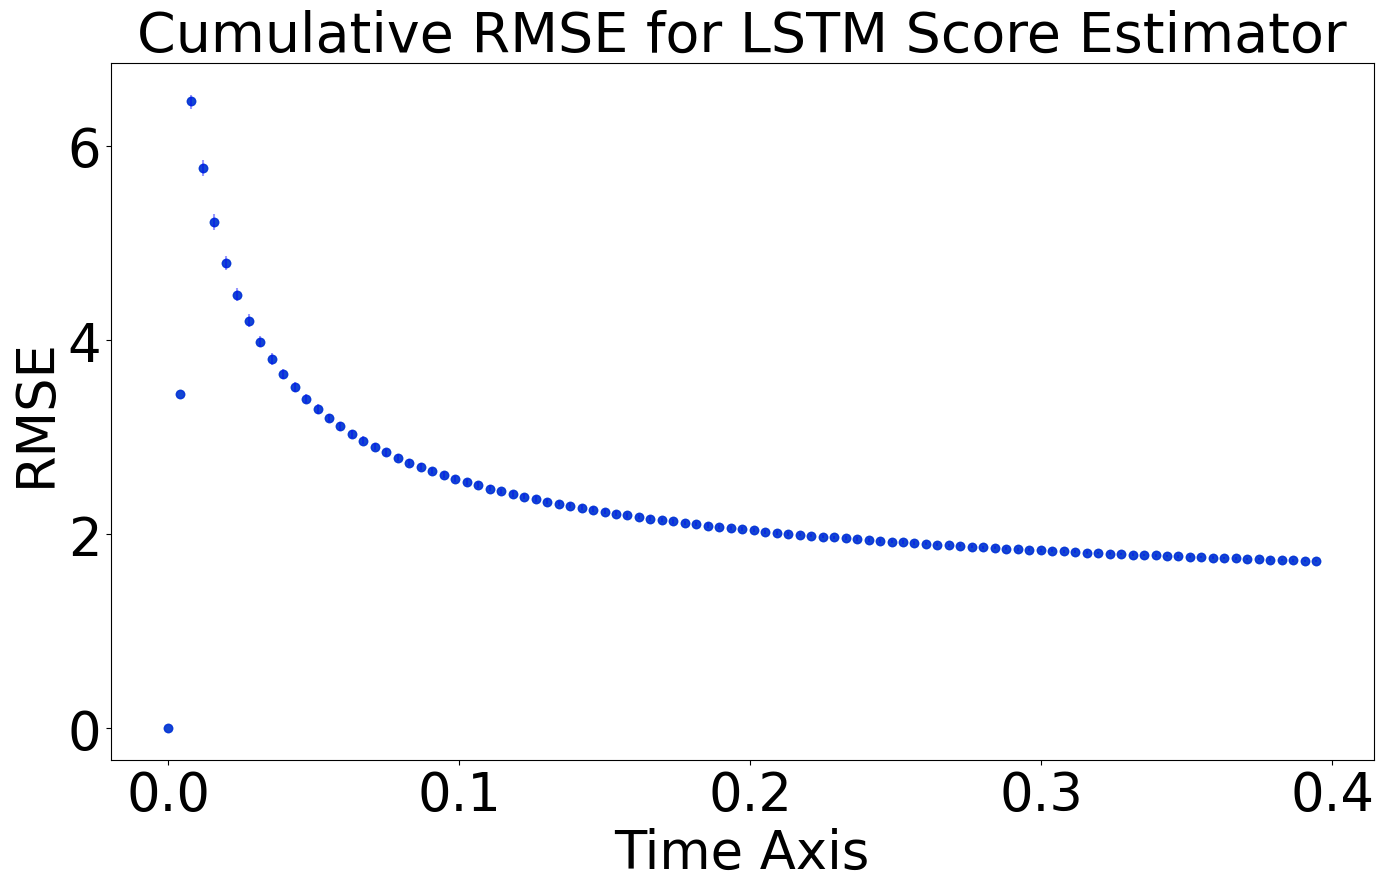

Final time cumulative RMSE local-time error 1.721410318331256 with final IQR (1.7093760909600777, 1.733748424478432) at Nepoch 300

1.9625297780681978 0.04266218802878341 1.721410318331256
1.8676207447467934 0.04153849011724553 1.721410318331256
1.997679244131433 0.03624559170579933 1.721410318331256
1.8159619230033797 0.03605615171962895 1.721410318331256
1.871178891618376 0.03112468788992584 1.721410318331256
1.8763696571033734 0.04246560003476496 1.721410318331256
1.8681749080574488 0.04358703841718636 1.721410318331256
1.8876405305543245 0.036963605437136726 1.721410318331256


In [6]:
curr_rmse = np.inf
toSave = False
for Nepoch in config.max_epochs:
    try:
        num_diff_times = 1
        save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fMullerBrown_DriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
            ".", "")
        all_true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse)
        if total_local_errors[-1]  < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fMullerBrown_DriftTrack_{Nepoch}Nep_PM_LSTM").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with final IQR {total_local_errors_minq[-1],total_local_errors_maxq[-1]} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        continue